# Import Libraries

In [2]:
#!pip install pytorch_tabnet

In [325]:
import os
import warnings
warnings.filterwarnings("ignore", message="Device used : cpu", category=UserWarning)

import numpy as np
import pandas as pd
import polars as pl


# visual
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold 
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor,Pool
import xgboost as xgb

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration

In [213]:
class config:
    METRIC = 'RMSE' #RMSE or SMAPE
    RANDOM_STATE=100  
    FRAC = 0.2
    N_FOLD = 5
    
class paths:
    # kaggle環境ならTrue
    if 'KAGGLE_URL_BASE' in set(os.environ.keys()):
        common_path = "/kaggle/input/amp-parkinsons-disease-progression-prediction"
    
    # colaboratory環境ならTrue
    if 'COLAB_GPU' in set(os.environ.keys()):
        common_path = "/content/drive/MyDrive/AMP"
    
    SAMPLE_SUBMISSION = common_path + "/example_test_files/sample_submission.csv"
    SUPPLEMENTAL_CLINICAL_DATA = common_path + "/supplemental_clinical_data.csv"
    TRAIN_CLINICAL_DATA = common_path + "/train_clinical_data.csv"
    TRAIN_PEPTIDES = common_path + "/train_peptides.csv"
    TRAIN_PROTEINS = common_path + "/train_proteins.csv"
    TEST_CLINICAL_DATA = common_path + "/example_test_files/test.csv"
    TEST_PEPTIDES = common_path + "/example_test_files/test_peptides.csv"
    TEST_PROTEINS = common_path + "/example_test_files/test_proteins.csv"

# Function Definition

## display_feature_importance 

In [5]:
def display_feature_importance(feature_list,model):

    # 特徴量重要度を保管する dataframe を用意
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = feature_list
    feature_importance['importance'] = model.feature_importances_

    print('****************************') 
    display(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False)[:20])

    # order = list(feature_importance.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:30]
    # # 可視化
    # plt.figure(figsize=(10, 10))
    # sns.barplot(x="importance",y="feature",data=feature_importance,order=order)
    # plt.title('importance')
    # plt.tight_layout()
    # plt.show()

## score_cal

In [6]:
def score_cal(y_true, y_pred,metric = config.METRIC):
  if metric == 'SMAPE':
    y_true = y_true + 1
    y_pred = y_pred + 1
    smap = np.zeros(len(y_true))
    num = np.abs((y_true) - (y_pred))
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = ((y_true)!=0)|((y_pred)!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    ret = 100 * np.mean(smap)
  if metric == 'RMSE':
    ret = np.sqrt(mean_squared_error(y_true,y_pred))

  return ret

## fit_catboost_fold1

In [7]:
def fit_catboost_fold1(X,y):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config.FRAC, random_state=config.RANDOM_STATE,shuffle=True)

  train_pool = Pool(X_train, y_train)
  model = CatBoostRegressor(random_seed=config.RANDOM_STATE,logging_level='Silent',eval_metric = config.METRIC)
  model.fit(train_pool,plot=False, verbose=False)  

  test_score = score_cal(y_val, model.predict(X_val))
  print('****************************')
  print(f"Test data average score : {test_score:.4f}"," seed ", config.RANDOM_STATE)

  return model,test_score

# Load Data

In [36]:
train_clinical = pd.read_csv(paths.TRAIN_CLINICAL_DATA)
train_peptides = pd.read_csv(paths.TRAIN_PEPTIDES)
train_proteins = pd.read_csv(paths.TRAIN_PROTEINS)
supplemental_clinical = pd.read_csv(paths.SUPPLEMENTAL_CLINICAL_DATA)
#print('Correct label:Proteins shape: (232741, 5) Peptides shape: (981834, 6) Clinical shape: (2615, 8)')
print('Proteins shape:',train_proteins.shape)
print('Peptides shape:',train_peptides.shape)
print('Clinical shape:',train_clinical.shape)
print('supplemental_clinical shape:',supplemental_clinical.shape)

test_clinical = pd.read_csv(paths.TEST_CLINICAL_DATA)
test_peptides = pd.read_csv(paths.TEST_PEPTIDES)
test_proteins = pd.read_csv(paths.TEST_PROTEINS)
sample_submission= pd.read_csv(paths.SAMPLE_SUBMISSION)
print('Proteins shape:',test_proteins.shape)
print('Peptides shape:',test_peptides.shape)
print('Clinical shape:',test_clinical.shape)


,visit_month,patient_id,UniProt,NPX,group_key
visit_id,,,,,
3342_6,6,3342,Q9Y6R7,295860000.0,6
50423_0,0,50423,Q9Y6R7,439208000.0,0


# Data Cleaning

In [48]:
train_clinical.replace({'On':1,'Off':0},inplace=True)
supplemental_clinical.replace({'On':1,'Off':0},inplace=True)

#欠損値処理
train_clinical.dropna(subset=['updrs_1'],inplace=True)
train_clinical.dropna(subset=['updrs_2'],inplace=True)

#以下は要精査
train_clinical.dropna(subset=['updrs_3'],inplace=True) 
train_clinical['upd23b_clinical_state_on_medication'] = train_clinical['upd23b_clinical_state_on_medication'].fillna(0)
train_clinical['updrs_4'] = train_clinical['updrs_4'].fillna(0)

#お試し。数値情報のlog化
train_peptides['PeptideAbundance'] = train_peptides['PeptideAbundance'].apply(np.log)
#train_peptides[['PeptideAbundance']].describe()
train_proteins['NPX'] = train_proteins['NPX'].apply(np.log)
#train_proteins[['PeptideAbundance']].describe()

train_clinical.isna().sum()

# Todo updrs_4は欠損値埋めしたいものの、適切な値がない… -> エラー避けるため0埋め

visit_id                               0
patient_id                             0
visit_month                            0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
dtype: int64

# common

In [10]:
#sort用にキー列のみ抽出
train_sort = train_clinical[['visit_id','patient_id','visit_month']]

# Feature Engineering

In [217]:
#--- clinical ---#
train_clinical
train_peptides
train_proteins

#--- peptides ---#

def encoder(df,type='pep'):
    if type == 'pep':
        key='Peptide'
        agg_value='PeptideAbundance'
    else:
        key='UniProt'
        agg_value='NPX'

    #UniProtごとの集計
    df_agg_ = pl.DataFrame(df).groupby([key],maintain_order=True).agg([
            pl.mean(agg_value).suffix("_mean_by_id"),
            pl.std(agg_value).suffix("_std_by_id"),
            pl.max(agg_value).suffix("_max_by_id"),
            pl.median(agg_value).suffix("_med_by_id"),
    ]).to_pandas()

    df_agg = df[['visit_id',key,agg_value]].merge(df_agg_,on=key)

    df_agg['Diff_' + agg_value + '_ori_mean'] = df_agg[agg_value] - df_agg[agg_value + '_mean_by_id']
    df_agg['Div_' + agg_value + '_ori_mean'] = df_agg[agg_value] / df_agg[agg_value + '_mean_by_id']
    df_agg['Div_' + agg_value + '_ori_std'] = df_agg[agg_value] / df_agg[agg_value + '_std_by_id']
    df_agg['Div_' + agg_value + '_max_std'] = df_agg[agg_value + '_max_by_id'] / df_agg[agg_value + '_std_by_id']
    df_agg['Div_' + agg_value + '_med_std'] = df_agg[agg_value + '_med_by_id'] / df_agg[agg_value + '_std_by_id']
    
    #不要行の削除
    df_agg.drop([key,agg_value + '_mean_by_id',agg_value + '_std_by_id',],axis=1,inplace=True)

    #PeptideAbundanceのagg
    df_agg_ret = pl.DataFrame(df_agg).groupby(['visit_id'],maintain_order=True).agg([
            pl.mean('*').suffix("_mean_by_id"),
            pl.std('*').suffix("_std_by_id"),
            pl.max('*').suffix("_max_by_id"),
            pl.median('*').suffix("_med_by_id"),
    ]).to_pandas()
    
    return df_agg_ret

en_peptides = encoder(train_peptides,type = 'pep')
en_proteins = encoder(train_proteins,type = 'pro')

print('shape',en_peptides.shape,en_proteins.shape)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,0.803379
1,55_0,0,55,O00533,GNPEPTFSWTK,0.894143
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,0.912502
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,0.843181
4,55_0,0,55,O00533,SMEQNGPGLEYR,0.848305
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,0.917522
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,0.895427
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,0.832485
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,0.763155


In [283]:
#peptide
df1 = train_clinical.merge(train_peptides[['visit_id','Peptide','PeptideAbundance']],on='visit_id')
df2 = df1[['Peptide','updrs_1']].reset_index(drop=True)

df2.dropna(inplace=True)

#95% clipping
df2['updrs_1'] = df2['updrs_1'].clip(lower=None, upper=df2['updrs_1'].quantile(0.95))

df3 = df2.groupby('Peptide')['updrs_1'].agg(['mean', 'median']).reset_index()

df4 = df3.sort_values('mean').reset_index(drop=True)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Float64Index'

In [313]:
df4['Peprank'] = np.ceil((df3.index+1).astype('Int64') / 100)
df_peprank = df4[['Peptide','Pep_rank']]

df5 = df1[['visit_id','updrs_1','Peptide']].merge(df_peprank,on='Peptide')
df5.groupby('updrs_1')['Pep_rank'].mean()

updrs_1
0.0     5.425775
1.0     5.429080
2.0     5.439205
3.0     5.427363
4.0     5.436521
5.0     5.449333
6.0     5.468334
7.0     5.475608
8.0     5.484698
9.0     5.499044
10.0    5.506275
11.0    5.508307
12.0    5.546876
13.0    5.499838
14.0    5.595425
15.0    5.647405
16.0    5.579545
17.0    5.563841
18.0    5.583569
19.0    5.503659
20.0    5.517775
21.0    5.476912
22.0    5.597807
23.0    5.934256
24.0    5.565463
25.0    5.553878
26.0    5.514574
27.0    6.061516
28.0    5.396308
33.0    5.329241
Name: Pep_rank, dtype: float64

# Train ALL 学習用trainの作成

In [206]:
def make_df_all(df_cli,df_pro,df_pep):
  df_propep = df_pro.merge(df_pep,on='visit_id',how='left')
  df_all = df_cli.merge(df_propep,on='visit_id',how='left')
  return df_all

#train_clinical_toall = train_clinical.merge(train_te_month_agg,on='visit_month',how='left')
#train_clinical_toall.shape,train_proteins_feature.shape,train_peptides_feature.shape


train_all = make_df_all(train_clinical,en_proteins,en_peptides)
train_all = train_all.dropna()
#train_all = make_df_all(train_clinical_toall,train_proteins_feature,train_peptides_feature)
print('shape',train_all.shape)

train_all.head()

#train_all.describe()

#train_all.columns
#train_proteins_feature.columns
#train_peptides_feature.columns

shape (1058, 72)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,NPX_mean_by_id,NPX_max_by_id_mean_by_id,...,Div_PeptideAbundance_max_std_max_by_id,Div_PeptideAbundance_med_std_max_by_id,PeptideAbundance_med_by_id,PeptideAbundance_max_by_id_med_by_id,PeptideAbundance_med_by_id_med_by_id,Diff_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_mean_med_by_id,Div_PeptideAbundance_ori_std_med_by_id,Div_PeptideAbundance_max_std_med_by_id,Div_PeptideAbundance_med_std_med_by_id
0,55_0,55,0,10.0,6.0,15.0,0.0,0.0,0.904912,0.931380,...,228.641473,226.063741,0.890880,0.916614,0.881252,0.010716,1.012082,57.634559,59.433268,57.272397
2,55_6,55,6,8.0,10.0,34.0,0.0,0.0,0.902889,0.931468,...,228.641473,226.063741,0.887505,0.916544,0.881288,0.008254,1.009364,57.725259,59.441560,57.287661
4,55_12,55,12,10.0,10.0,41.0,0.0,1.0,0.905464,0.930784,...,228.641473,226.063741,0.890274,0.916001,0.880814,0.011807,1.013453,57.475221,59.241400,57.013595
8,55_36,55,36,17.0,18.0,51.0,0.0,1.0,0.903894,0.930200,...,228.641473,226.063741,0.888460,0.916654,0.881156,0.011028,1.012579,57.905403,59.540802,57.306347
15,942_6,942,6,8.0,2.0,21.0,0.0,0.0,0.896468,0.932144,...,228.641473,226.063741,0.882765,0.916544,0.881370,0.002178,1.002416,57.268804,59.605457,57.380854


# Fit

In [315]:
df_train = train_all.copy()
df_train.reset_index(drop=True,inplace=True)


groups = df_train['patient_id'].values
X_train = df_train.drop(['visit_id','patient_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication'],axis=1)
y_train = df_train['updrs_1']

#NN用に退避
X_train_NN = X_train.copy()
y_train_NN = y_train.copy()
#GroupKFold

## Tree

In [214]:
models = []                     
preds = np.zeros(len(test))
scores = 0.0   
best_score = 99999
fi_df = pd.DataFrame()
oof = np.zeros(len(X_train))


#X_train, X_valtest, y_train, y_valtest = train_test_split(train_X.values,train_y.values,test_size=config.FRAC,random_state=config.RANDOM_STATE)
gkf = GroupKFold(n_splits=config.N_FOLD)

for fold, (trn_idx, val_idx) in enumerate(gkf.split(X_train, y_train,groups=groups)): 
    X_trn, y_trn = X_train.loc[trn_idx], y_train[trn_idx]
    X_val, y_val = X_train.loc[val_idx], y_train[val_idx]

    # モデルの学習
    #model = lgb.LGBMClassifier(importance_type='gain')
    model = lgb.LGBMRegressor(n_estimators=30000,
    max_depth=5,
    colsample_bytree=0.5,
    learning_rate=0.06,
    importance_type='gain',
    random_state=config.RANDOM_STATE)
    model.fit(X_trn, y_trn
              ,eval_metric='RMSE' 
              ,eval_set=[(X_val, y_val)]
              ,callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
              )
    train_pool = Pool(X_trn, y_trn)
    validate_pool = Pool(X_val, y_val) 

    #model = CatBoostRegressor(loss_function='RMSE',random_seed=config.RANDOM_STATE,logging_level='Silent')
    #model.fit(train_pool,eval_set=validate_pool
    #          ,early_stopping_rounds=10,use_best_model=True,plot=False,verbose=False)    
    
    # validation データでの予測結果
    score = score_cal(y_val,model.predict(X_val))
    oof[val_idx] = model.predict(X_val)
    models.append(model)

    if score < best_score:
        best_score = score
        best_model = model
        best_fold = fold+1

      # feature_importances_の記録
    _df = pd.DataFrame()
    _df['feature'] = X_trn.columns
    _df['FI'] = model.feature_importances_
    _df['fold'] = fold
    fi_df = pd.concat([fi_df, _df])

    #preds += model.predict(test_X_te)[:,1] / config.N_FOLD

    print("Fold :" , fold+1)
    
    #loop
    
oof_df = pd.DataFrame({
    'oof': oof,
    'target':y_train
})

print(f"fold best score : {best_score:.4f}"," FOLD ",best_fold)
tot_auc = score_cal(y_train, oof)
print(f"Overall score: {tot_auc:.5f}")
print(f"Overall SMAPE Score: {score_cal(y_train, oof,'SMAPE'):.5f}")

Fold : 1
Fold : 2
Fold : 3
Fold : 4
Fold : 5
fold best score : 4.6307  FOLD  2
Overall score: 5.23524
Overall SMAPE Score: 57.18254


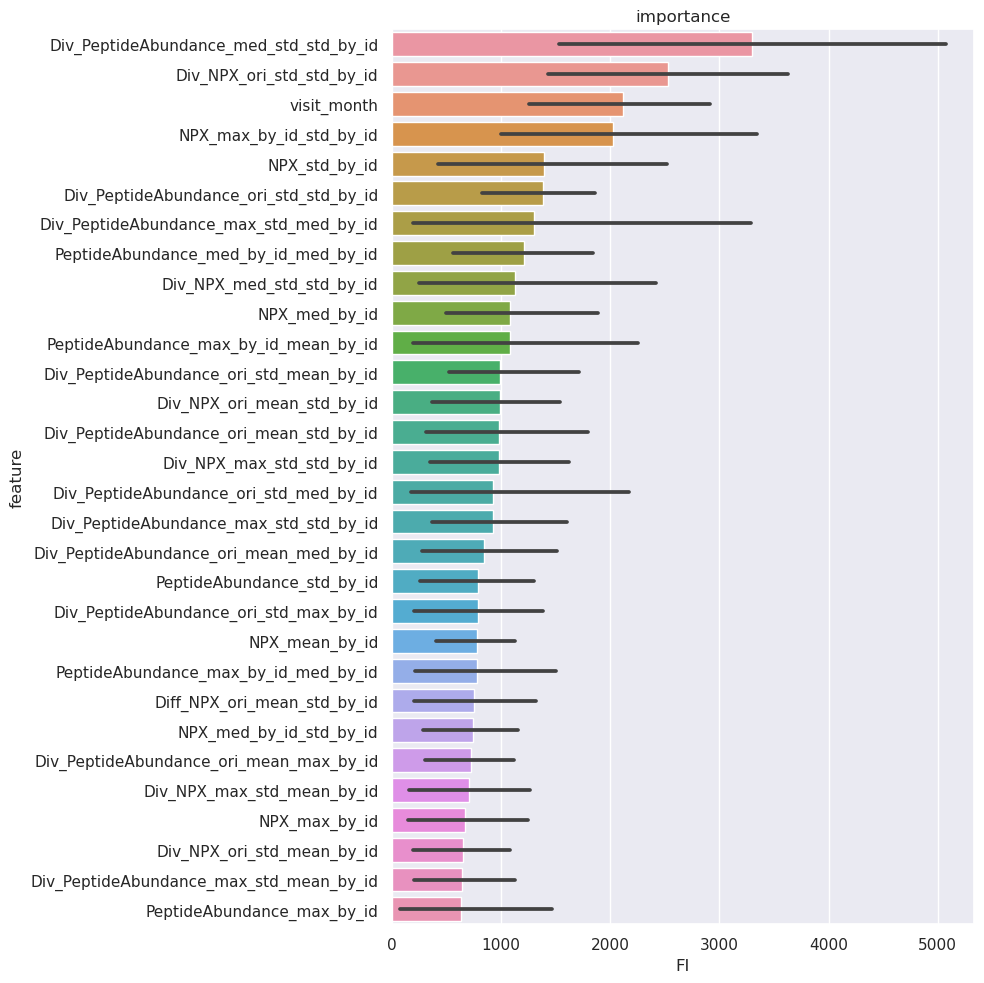

In [215]:
# feature_importances_ 上位20個の図示
TOP = 30

order = fi_df.groupby('feature')['FI'].mean().sort_values(ascending=False)[:TOP].index
# 可視化
plt.figure(figsize=(10, 10))
sns.barplot(x="FI",y="feature",data=fi_df,order=order)
plt.title('importance')
plt.tight_layout()
plt.show()

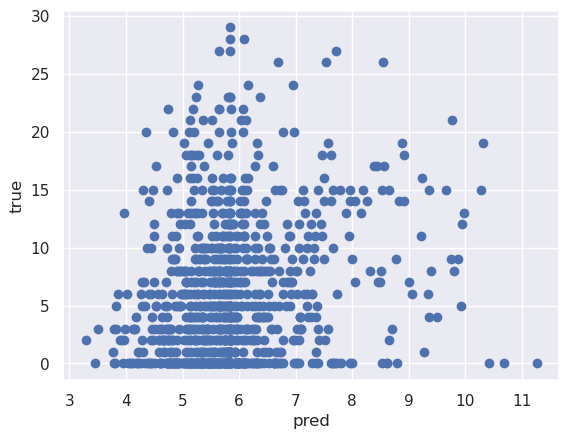

In [191]:
# 散布図の描画
plt.scatter(oof_df['oof'], oof_df['target'])
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## NN

In [374]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_NN)
X_train_NN = scaler.transform(X_train_NN)

train_X_NN, val_X_NN, train_y_NN, val_y_NN = train_test_split(X_train_NN, y_train_NN.values, test_size = config.FRAC, random_state=config.RANDOM_STATE)

train_X_NN = torch.from_numpy(train_X_NN).float()
train_y_NN = torch.from_numpy(train_y_NN).float()
val_X_NN = torch.from_numpy(val_X_NN).float()
val_y_NN = torch.from_numpy(val_y_NN).float()

#test_X = torch.from_numpy(test_X.values).float()

train_td=TensorDataset(train_X_NN, train_y_NN)
train_loader = DataLoader(train_td, batch_size=15, shuffle=True)

In [362]:
# 線形回帰ネットワークのclassをnn.Moduleの継承で定義
class Regression(nn.Module):
    # コンストラクタ(インスタンス生成時の初期化)
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(65, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 1)
 
    # メソッド(ネットワークをシーケンシャルに定義)
    def forward(self, x):
        x = nn.functional.relu(self.linear1(x))
        x = nn.functional.relu(self.linear2(x))
        x = nn.functional.relu(self.linear3(x))
        x = nn.functional.relu(self.linear4(x))
        x = nn.functional.relu(self.linear5(x))
        x = self.linear6(x)
        return x 
    
#model = Net()


https://watlab-blog.com/2021/06/14/pytorch-nonlinear-regression/

In [377]:
model = Regression()
#optimizer = optim.RMSprop(model.parameters(), lr=0.01) 
optimizer = optim.Adam(model.parameters(),lr=0.1,betas=(0.9,0.99),eps=1e-09)
criterion = nn.MSELoss()       
iteration = 10
losses = []

for epoch in range(iteration): 
    total_loss = 0
     
    for train_X_NN, train_y_NN in train_loader:
        train_X_NN, train_y_NN = Variable(train_X_NN), Variable(train_y_NN)
        optimizer.zero_grad()
        
        output = model(train_X_NN)
        loss = criterion(output, train_y_NN)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() #loss.data[0]で記述するとPyTorch0.5以上ではエラーが返る
        losses.append(loss.item())    
     
    if (epoch+1) % (iteration/10) == 0:
        print(epoch+1, total_loss)
     
val_X_NN, val_y_NN = Variable(val_X_NN), Variable(val_y_NN)
y_pred = model(val_X_NN).data.numpy() 
score_cal(y_pred,val_y_NN)



array([[7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.491202 ],
       [7.7003126],
       [7.7003126],
       [7.6796293],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.4867764],
       [7.6671743],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],
       [7.7003126],


In [ ]:
from statistics import mean

# 分割前のデータとして配列等をSeriesあるいはDataFrameに変換している
train_data = pd.Series(〜)

# fold毎のモデル、正解率、損失を格納する配列
nets, accs, losses = [], [], []

# n_splits分割（ここでは5分割）してCV
kf = KFold(n_splits=5, shuffle=True, random_state=2020)

for train_idx, valid_idx in kf.split(train_data):
    # train_idx、valid_idxにはインデックスの値が格納されている
    train = train_data.iloc[train_idx].reset_index(drop=True)
    valid = train_data.iloc[valid_idx].reset_index(drop=True)
    # train_one関数では実際の訓練が行われる
    net, acc, loss = train_one(train, valid)
    nets.append(net)
    accs.append(acc)
    losses.append(loss)

# CVの評価としてfold毎のvalidの結果を平均したものを使う（他にも手法はあるが）
print("oof acc: {:4f}".format(mean(accs)))
print("oof loss: {:4f}".format(mean(losses)))


# PyTorchを推論モードにする
with torch.no_grad():
    for test_path in test_data:
        img = Image.open(test_path)
        _id = int(test_path.split('/')[-1].split('.')[0])

        transform = ImageTransform(SIZE, MEAN, STD)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(DEVICE)

        pred = 0.0
        for i in range(5):
            net = nets[i]
            net.eval()
            outputs = net(img)
            preds = F.softmax(outputs, dim=1)[:, 1].tolist()
            pred += preds[0]
        
        id_list.append(_id)

        # 確率の平均を算出
        pred_list.append(pred / SPLITS)